In [37]:
import os
import numpy as np
import nibabel as nib

from utils import calculate_dice_score
from em_algo import ExpectationMaximization

## Load Data

In [38]:
patient = 5

In [39]:
# Load the two NIfTI images
T1_path = f'data/{patient}/T1.nii'
T2_path = f'data/{patient}/T2_FLAIR.nii'
label_path = f'data/{patient}/LabelsForTesting.nii'
relative_save_path = f'results/mutilmodals/{patient}/'


### Load the images from the path
T1 = nib.load(T1_path)
T1_np_img = T1.get_fdata()
T2 = nib.load(T2_path)
T2_np_img = T2.get_fdata()
labels = nib.load(label_path)
labels_np_img = labels.get_fdata()

In [40]:
# Perform Skull Stripping to get the brain mask for WM, GM, and CSF
## Isolate the brain voxels using the label
#### Get the indices of the brain voxels
brain_voxels_indices = np.where(labels_np_img > 0)
#### Get the brain voxels from the T1 image using the indices get from the label
T1_skull_stripped = T1_np_img[brain_voxels_indices]
T2_skull_stripped = T2_np_img[brain_voxels_indices]

### Stack the T1 and T2 images to get the multi-modal image
X = np.vstack((T1_skull_stripped, T2_skull_stripped)).T

## EM Algorithm

In [41]:
## Min Max scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = scaler.fit_transform(X)

Iteration:  0  --- Log Likelihood:  15.447149573922605  --- Time (s):  0.08488082885742188


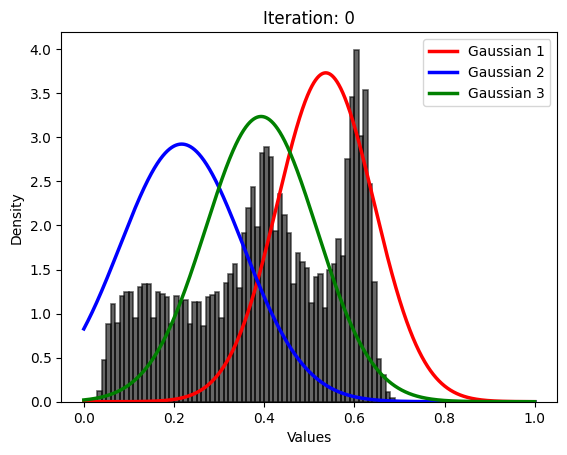

Iteration:  1  --- Log Likelihood:  15.692723420703652  --- Time (s):  0.10151505470275879
Iteration:  2  --- Log Likelihood:  15.815883354669667  --- Time (s):  0.08892226219177246
Iteration:  3  --- Log Likelihood:  15.864492946023576  --- Time (s):  0.08996009826660156
Iteration:  4  --- Log Likelihood:  15.887488950241472  --- Time (s):  0.08710813522338867
Iteration:  5  --- Log Likelihood:  15.904799269852356  --- Time (s):  0.08183598518371582
Iteration:  6  --- Log Likelihood:  15.923327818263552  --- Time (s):  0.0863640308380127
Iteration:  7  --- Log Likelihood:  15.943549831804953  --- Time (s):  0.08270788192749023
Iteration:  8  --- Log Likelihood:  15.96256535813059  --- Time (s):  0.08199191093444824
Iteration:  9  --- Log Likelihood:  15.9782505846342  --- Time (s):  0.0825650691986084
Iteration:  10  --- Log Likelihood:  15.990859265188787  --- Time (s):  0.08508586883544922
Iteration:  11  --- Log Likelihood:  16.001371357496904  --- Time (s):  0.08527374267578125
It

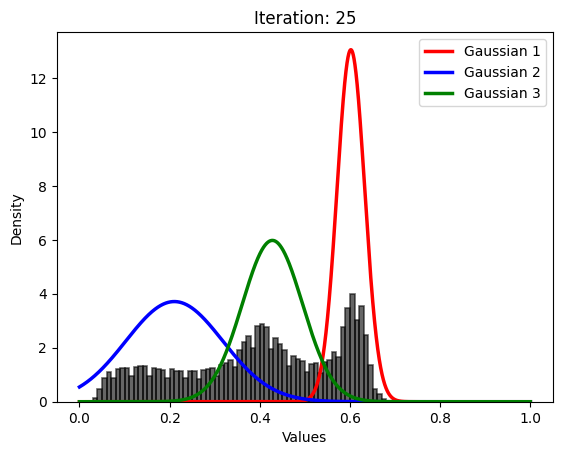

Iteration:  26  --- Log Likelihood:  16.065116553082813  --- Time (s):  0.08587121963500977
Iteration:  27  --- Log Likelihood:  16.066121809139204  --- Time (s):  0.08517122268676758
Iteration:  28  --- Log Likelihood:  16.06697745652521  --- Time (s):  0.08469986915588379
Iteration:  29  --- Log Likelihood:  16.067704134789068  --- Time (s):  0.08614706993103027
Iteration:  30  --- Log Likelihood:  16.068319111978088  --- Time (s):  0.08613395690917969
Iteration:  31  --- Log Likelihood:  16.06883854456248  --- Time (s):  0.08655214309692383
Iteration:  32  --- Log Likelihood:  16.06927726987176  --- Time (s):  0.09015989303588867
Iteration:  33  --- Log Likelihood:  16.06964768779276  --- Time (s):  0.09407901763916016
Iteration:  34  --- Log Likelihood:  16.06995969656292  --- Time (s):  0.09380292892456055
Iteration:  35  --- Log Likelihood:  16.070221474632522  --- Time (s):  0.0979461669921875
Iteration:  36  --- Log Likelihood:  16.070440163041884  --- Time (s):  0.098329067230

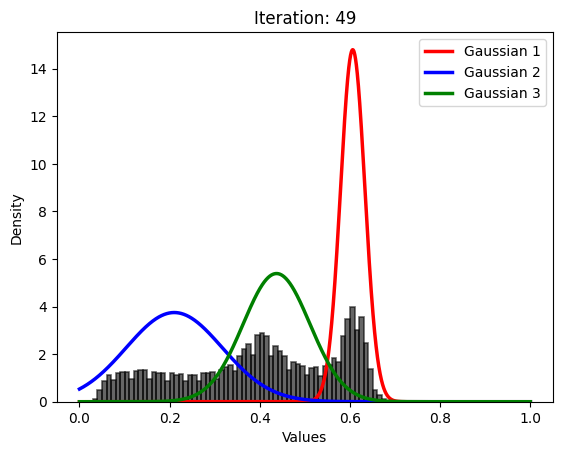

In [42]:
# Initialize the Expectation Maximization algorithm
em = ExpectationMaximization(X, k=3, max_iter=50, type='kmeans', plot_step=25, save_path=relative_save_path, show_plot=True, stop_criterion=1e-6)
alphas, mus, covars, W = em.fit()

## Postprocessing

Sort the means of the Gaussian components. This helps us map the classes to the intensity ranges.  
	•	The smallest mean will be assigned to CSF (1).  
	•	The middle mean will be assigned to GM (2).  
	•	The largest mean will be assigned to WM (3).  

In [43]:
# Assign each voxel to the cluster with the highest probability
voxel_assignments = np.argmax(W, axis=1)  # Get the index of the highest responsibility for each voxel
# Create a new 3D image with the same shape as the original brain image
segmented_image = np.zeros_like(T1_np_img)
# Map the voxel assignments back to the 3D segmented image using the brain_voxels_indices
segmented_image[brain_voxels_indices] = voxel_assignments + 1  # +1 to make the clusters 1, 2, 3

In [44]:
## 1 - CSF, 2 - GM, 3 - WM 
## Sort the clusters based on the mean intensity of the voxels in each cluster
sorted_mean_indices = np.argsort(np.mean(mus, axis=1)) + 1
## Assign the clusters to the correct class
class1_idx = np.where(segmented_image == sorted_mean_indices[0])
class2_idx = np.where(segmented_image == sorted_mean_indices[1])
class3_idx = np.where(segmented_image == sorted_mean_indices[2])
segmented_image[class1_idx] = 1
segmented_image[class2_idx] = 2
segmented_image[class3_idx] = 3

# Save the segmented image
segmented_img_nifti = nib.Nifti1Image(segmented_image, T1.affine)
nib.save(segmented_img_nifti, os.path.join(relative_save_path, f'segmented_brain_{patient}.nii'))

print("Segmented brain image saved as " + os.path.join(relative_save_path, f'segmented_brain_{patient}.nii'))

Segmented brain image saved as results/mutilmodals/5/segmented_brain_5.nii


## Evaluation

In [45]:
# Calculate the Dice score between the predicted labels and the ground truth
dice_scores = calculate_dice_score(label_path, os.path.join(relative_save_path, f'segmented_brain_{patient}.nii'))    
print(dice_scores)
print('Average Dice Score: ', np.mean(list(dice_scores.values())))

{1: 0.8650661261147125, 2: 0.8462341830751188, 3: 0.8910175541927499}
Average Dice Score:  0.8674392877941935
